In [43]:
import IPython.display as ipd 
import librosa
import librosa.display
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

In [2]:
# Audio files and CSV file containing metadata
file_path = 'Dataset/'
df = pd.read_csv('Dataset/UrbanSound8K.csv')

In [3]:
#pd.set_option('display.max_rows', None)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
# Checking class distribution of each fold

appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,drilling,children_playing,air_conditioner,dog_bark,street_music,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


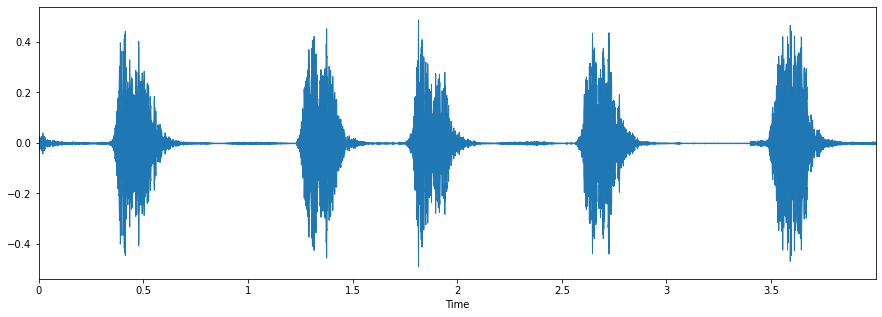

In [5]:
# Dog Barking audio
fname1 = 'Dataset/fold10/30344-3-0-4.wav'  
data, sampling_rate = librosa.load(fname1)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Play the audio file.
ipd.Audio(fname1)

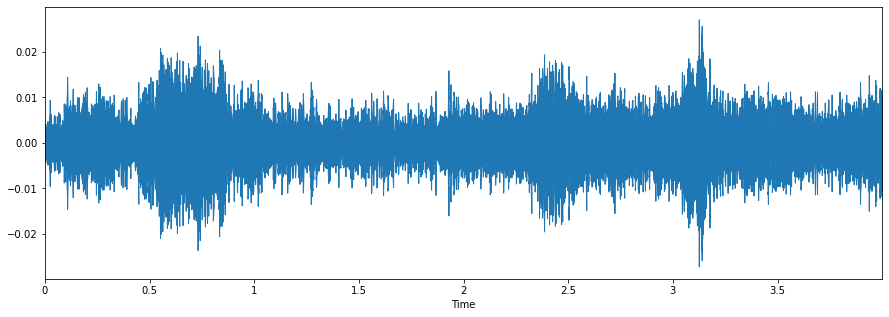

In [6]:
# Children playing audio
fname2 = 'Dataset/fold5/100263-2-0-117.wav'  
data, sampling_rate = librosa.load(fname2)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Play the audio file.
ipd.Audio(fname2)

In [7]:
fold = df['fold'].to_numpy()
fname = df['slice_file_name'].to_numpy()
cname = df['class'].to_numpy()
i = 300
path1 = 'Dataset/fold' + str(fold[i]) + '/' + fname[i]
j = 150
path2 = 'Dataset/fold' + str(fold[j]) + '/' + fname[j]
dat1, sampling_rate1 = librosa.load(path1)
dat2, sampling_rate2 = librosa.load(path2)

Text(0.5, 1.0, 'Power spectrogram: car_horn')

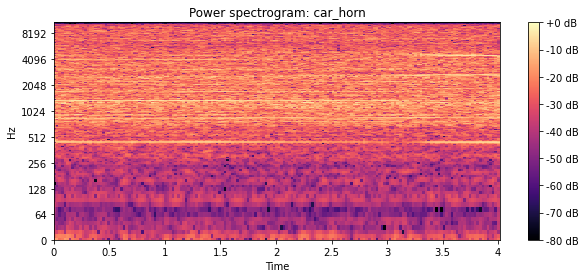

In [47]:
plt.figure(figsize=(10, 4))
# why abs ?
D = np.abs(librosa.stft(dat1))
# what is np.max ?
S_db = librosa.amplitude_to_db(D, ref=np.max) 
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Power spectrogram: {cname[i]}')

Text(0.5, 1.0, 'Power spectrogram: engine_idling')

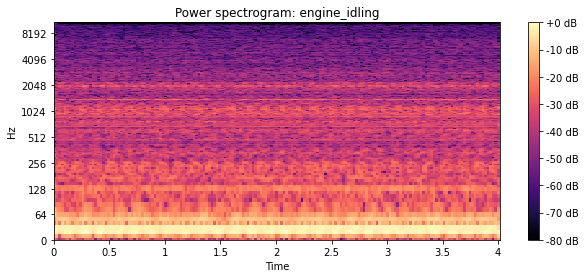

In [9]:
plt.figure(figsize=(10, 4))
D = np.abs(librosa.stft(dat2))
S_db = librosa.amplitude_to_db(D, ref=np.max) 
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Power spectrogram: {cname[j]}')

### Extracting features using Librosa

In [10]:
# Feature extraction using librosa

def features_extract(file):
    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
    
    # extract the features
    feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    feature_norm = (feature - feature.mean())/feature.std()
    
    # feature scaling
    scaled_feature = np.mean(feature_norm.T,axis=0)
    
    # return the scaled features
    return scaled_feature

# list containg all the features
extracted = []

# for each row in the csv
for index_num,row in tqdm(df.iterrows()):
    
    # get the file 
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    
    # get file label
    final_class_labels = row['class']
    
    # extract feature
    data= features_extract(file_name)
    
    # store it in a list
    extracted.append([data,final_class_labels])

3553it [04:12, 21.77it/s]C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8324it [09:32, 30.36it/s]C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [09:58, 14.60it/s]


In [11]:
# Creating DataFrame from the extracted features:
df_extracted = pd.DataFrame(extracted,columns=['feature','label'])

# Adding 'fold' column to new DataFrame which contains extracted feature and label
df_extracted['fold'] = df['fold']
df_extracted.head()

,feature,label,fold
0,"[-4.364279, 1.7399223, -2.5809777, -0.8880701,...",dog_bark,5
1,"[-5.889389, 1.6368701, -0.6791615, 0.954176, 0...",children_playing,5
2,"[-5.933864, 1.6941134, -0.54209054, 0.7833292,...",children_playing,5
3,"[-5.9232674, 1.5859518, -0.43936306, 0.8789803...",children_playing,5
4,"[-5.923137, 1.6248747, -0.6416325, 0.9071426, ...",children_playing,5


### Constructing ANN model:

In [64]:
le = LabelEncoder()
y = np.array(df_extracted.label.tolist())

filter_size = 3
y = np_utils.to_categorical(le.fit_transform(y))

num_labels = y.shape[1]

# build model
model = Sequential()
model.add(Dense(512, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               20992     
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

### Pre-processing & Fitting the model:

In [65]:
predicted = []
actual = []

# Taking 1 fold for Validation and rest 9 folds for train sets.
# Using for loop so that each fold becomes validation set once and rest 9 as train set.

for i in range(1,11):
    validation_data = df_extracted[df_extracted['fold'] == i]
    train_data = df_extracted[df_extracted['fold'] != i]
    
    x = np.array(train_data.feature.tolist())
    y = np.array(train_data.label.tolist())
    
    x_val = np.array(validation_data.feature.tolist())
    y_val = np.array(validation_data.label.tolist())
    
    y = np_utils.to_categorical(le.fit_transform(y))
    y_val = np_utils.to_categorical(le.fit_transform(y_val))
    
    fitting = model.fit(x, y, batch_size=64, epochs=10, validation_data=(x_val, y_val), shuffle=False)
    pred = model.predict(x_val)
    
    predicted.append(pred)
    actual.append(y_val)

Epoch 1/10
123/123 [==============================] - 1s 5ms/step - loss: 2.2219 - accuracy: 0.2075 - val_loss: 1.9545 - val_accuracy: 0.2875
Epoch 2/10
123/123 [==============================] - 0s 4ms/step - loss: 1.9530 - accuracy: 0.2866 - val_loss: 1.8682 - val_accuracy: 0.3356
Epoch 3/10
123/123 [==============================] - 0s 4ms/step - loss: 1.7959 - accuracy: 0.3488 - val_loss: 1.7631 - val_accuracy: 0.4204
Epoch 4/10
123/123 [==============================] - 1s 5ms/step - loss: 1.6927 - accuracy: 0.3927 - val_loss: 1.7358 - val_accuracy: 0.4376
Epoch 5/10
123/123 [==============================] - 1s 4ms/step - loss: 1.5968 - accuracy: 0.4208 - val_loss: 1.7233 - val_accuracy: 0.4525
Epoch 6/10
123/123 [==============================] - 0s 4ms/step - loss: 1.5451 - accuracy: 0.4362 - val_loss: 1.7628 - val_accuracy: 0.4341
Epoch 7/10
123/123 [==============================] - 1s 4ms/step - loss: 1.4883 - accuracy: 0.4613 - val_loss: 1.7996 - val_accuracy: 0.4502
Epoch 

In [66]:
acc = []
for i in range(0,10):
    predict_conv = np.argmax(predicted[i],axis=1)
    actual_conv = np.argmax(actual[i],axis=1)
    acc.append(accuracy_score(actual_conv,predict_conv))
print("Accuracy for 10 fold cross validation:",np.mean(acc))

Accuracy for 10 fold cross validation: 0.7360672942395153


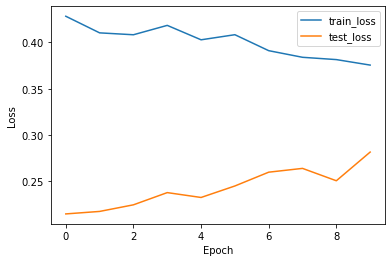

In [67]:
# Plotting ANN Loss

metrics = fitting.history
plt.plot(fitting.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

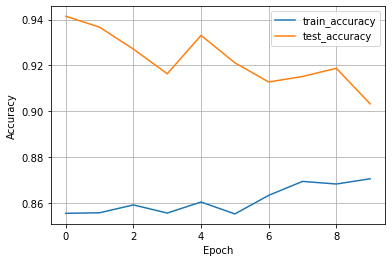

In [68]:
# Plotting ANN Accuracy

plt.plot(fitting.history['accuracy'], label='train_accuracy')
plt.plot(fitting.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)